<a href="https://colab.research.google.com/github/Classymotion/Smilegate/blob/main/Text_Style_Transfer_Smilegate_BART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SmileGate Style Dataset을 이용한 텍스트 스타일 변경 모델

- https://github.com/smilegate-ai/korean_smile_style_dataset

## References
- https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/pipelines#transformers.Text2TextGenerationPipeline
- https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/bart#transformers.BartForConditionalGeneration
- https://huggingface.co/docs/transformers/tasks/summarization
- https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate.early_stopping
- https://huggingface.co/docs/transformers/internal/generation_utils


In [1]:
!pip install transformers
!wget https://raw.githubusercontent.com/smilegate-ai/korean_smile_style_dataset/main/smilestyle_dataset.tsv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.8 MB/s eta 0:00:00
--2023-04-22 16:00:12--  https://raw.githubusercontent.com/smilegate-ai/korean_smile_style_dataset/main/smilestyle_dataset.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2357401 (2.2M) [text/plain]
Saving to: ‘smilestyle_dataset.tsv’

smilestyle_dataset. 100%[===================>]   2.25M  --.-KB/s    in 0.06s   

2023-04-22 16:00:13 (35.0 MB/s) - ‘smilestyle_dataset.tsv’ saved [2357401/2357401]



In [2]:
from google.colab import drive

drive.mount("/content/drive2")

Mounted at /content/drive2


In [3]:

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
)
from tokenizers import Tokenizer
from typing import Dict, List, Optional
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from IPython.display import display
from typing import Dict

In [4]:
df = pd.read_csv("smilestyle_dataset.tsv", sep="\t")
display(df.head())
display(df.isna().mean())
display(df.describe())
print(df.shape)

,formal,informal,android,azae,chat,choding,emoticon,enfp,gentle,halbae,halmae,joongding,king,naruto,seonbi,sosim,translator
0,안녕하세요. 저는 고양이 6마리 키워요.,안녕! 나는 고양이 6마리 키워.,휴먼. 반갑다. 안드로이드는. 고양이. 6마리. 소유중.,아이고 안녕하십니까~ 나는 그냥 고양이 6마리 키우고 있는 사람이여,하잉ㅋㅋ 나 떼걸룩 6마리 키운다!,ㅎㅇ 나 주인님 6마리 모심 ㅋㅋ,안녕!! >< 나는 고양이😺를 ➏ 마리 키우고있어!! 0_0,안녕안녕~! 나 고양이 6마리나 키운다? 완전 대박이징~,"안녕하십니까,, 저는 고양이 6마리 키웁니다.",안녕하신가~... 난 지금 고양이를 6마리 키우고 있다네,하유 시벌것 괭이놈 6마리 키우는데 힘들어 죽겟네,안녕하냐 ㅡㅡ 나 씹냥이 6마리나 키운다 하;,반갑소. 짐은 고양이를 6마리나 키우오.,안녕하냐니깐! 난 고양이를 6마리 키우고있다니깐!,안녕하시오! 소인은 고양이를 6마리 키우고 있소!,안녕… 난 고양이 6마리 키워 ㅠㅠ,반가운. 나는 6마리의 고양이를 소지하고 있다.
1,고양이를 6마리나요? 키우는거 안 힘드세요?,고양이를 6마리나? 키우는거 안 힘들어?,고양이. 6마리. 양육. 번거로운가.,아니 무슨 고양이를 6마리나? 거 키우는 거 안 힘든가?,엥? 6마리나? 안힘듬?ㅋㅋㅋㅋ,6마리? 에바아니냐 안 힘듦?,고양이를 6마리나?!! w(ﾟДﾟ)w 키우는거 안 힘듬?? (⊙_⊙;),고양이를 6마리나? 완전 대박~ 키우는 거 안 힘들어?!,"고양이를 6마리나 키우십니까? 안 힘드신지,,",고양이를 6마리나? 키우는거 힘들지 않는가?,니기럴 털만 날리는 거 키우기 안 힘들데?,아니 고양이를 6마리나? 안힘드냐?,고양이를 6마리나? 키우는게 수고스럽진 않소?,고양이를 6마리나? 키우는거 힘들지 않냐니깐?,고양이를 6마리나 키우고 있는 것이오? 힘들지 않소?,고양이..6마리나? ㅠ 키우는건 혹시 안힘들어..?,6마리의 고양이? 당신은 그들로부터 지치지 않습니까?
2,제가 워낙 고양이를 좋아해서 크게 힘들진 않아요.,내가 워낙 고양이를 좋아해서 크게 힘들진 않아.,안드로이드. 고양이. 선호. 힘들지. 않음.,내가 또 워~낙에 고양이를 좋아해서 크게 뭐 힘들진 않고,내가 고양이 좋아해서 딱히 안힘듬 ㅋㅋㅋ,ㄱㅊ 나 고양이 환장해서 힘든 것도 모름,뭐 나야 워낙에 고양이 좋아하니까 딱히 안힘드엉! \(@^0^@)/,내가 또 워~낙에 고양이를 좋아하잖아~ 그렇게 크~게 힘들진 않아 ㅎㅎ~,제가 워낙 고양이를 좋아해서 크게 힘들진 않습니다.,내가 워낙에...고양이가 좋아가지고 그렇게 힘들지 않어...^^,옘병 내가 좋아하니까 키워야지 시벌것,고양이 좋아한다고ㅡㅡ 1도 안힘듬 ㅡㅡ,과인은 고양이를 어여삐 어겨 그리 수고스럽진 않소,내가 고양이를 엄청 좋아해서 별로 힘들지 않다니깐!,소인 고양이를 엄청 좋아하기 때문에 별로 힘들지 않소이다.,내가 고양이 워낙 좋아해서..ㅠㅠ 크게 힘들진 않은 것 같아..,나는 고양이의 큰 애호가. 지치지 않는다.
3,가장 나이가 많은 고양이가 어떻게 돼요?,가장 나이가 많은 고양이가 몇 살이야?,제일. 나이많은. 고양이. 나이. 무엇.,그려 가장 나이가 많은 고양이가 몇살이여?,가장 나이 먹은 고양이가 몇살이야?,젤 낡은 고영희가 몇 살임?,가장 나이 먹은 고양인 몇 살이양? (´･ω･`)?,대박대박 완전 대박!! 그럼 제~일 나이 많은 고양이는 몇살이야~?!,가장 나이가 있는 고양이가 몇살입니까?,고양이들 중에서…가장 나이 먹을 애가 몇살인가?...,거 젤 빨리 뒤질 놈이 나이 얼마나 쳐먹었냐,가장 늙은애가 몇살인데,최고령 고양이의 나이는 어떻게 되는가?,가장 나이 많이 먹은 고양이가 몇 살 이냐니깐?!,나이를 가장 많이 먹은 고양이가 몇 살이오?,혹시.. 제일 나이 많은 고양이는.. 몇살이야..?ㅠ,가장 늙은 고양이가 몇 년입니까?
4,여섯 살입니다. 갈색 고양이에요.,여섯 살이야. 갈색 고양이지.,고양이. 갈색. 여섯살.,6살인데 갈색 고양이 있어~,이제 여섯살이고 갈색고양이임!,"6살, 갈색임",여설 살!! ㄱ^o^/ 색깔은 갈색! O(*￣▽￣*)ブ,"6살인 애 있는데, 완전 귀.여.워. 갈색 고양이야 진짜 대박이지?",6살된 갈색 아이가 있습니다.,저…갈색 고양이인데…여섯살이지~..,저 노망난 갈색놈이 6살 뒤룩뒤룩 쳐먹은 놈이여,여섯살 갈색냥인데 왜,여섯 살이오. 갈색 고양이오.,갈색 고양이가 여섯살이라니깐!,여섯 살에 갈색 고양이오,여섯살이야.. 갈색 ㅠㅠ 고양이야..ㅠ,여섯. 고양이는 갈색이다.


formal        0.063428
informal      0.063428
android       0.520918
azae          0.723347
chat          0.063428
choding       0.063428
emoticon      0.514980
enfp          0.544130
gentle        0.540351
halbae        0.515789
halmae        0.726586
joongding     0.063428
king          0.520918
naruto        0.514980
seonbi        0.514980
sosim         0.520918
translator    0.594062
dtype: float64

,formal,informal,android,azae,chat,choding,emoticon,enfp,gentle,halbae,halmae,joongding,king,naruto,seonbi,sosim,translator
count,3470,3470,1775,1025,3470,3470,1797,1689,1703,1794,1013,3470,1775,1797,1797,1775,1504
unique,3430,3417,1748,1025,3437,3390,1793,1679,1691,1784,1005,3396,1759,1779,1784,1758,1489
top,안녕하세요.,안녕.,반갑다.,아이고 안녕하십니까~ 나는 그냥 고양이 6마리 키우고 있는 사람이여,하이,왜?,안녕! (ﾉ*･ω･)ﾉ,안뇽~,안녕하십니까,안녕하신가…,왜 땜시?,ㅎㅇ,반갑소.,안녕하냐니깐!,안녕하시오!,안녕..,반가운.
freq,23,25,10,1,13,37,3,6,5,8,4,29,7,9,9,9,9


(3705, 17)


특정 문장을 다른 스타일의 문장으로 바꾸기 위해선, 한 row가 2개 이상의 NaN이 아닌 값이 있어야 한다. 

확인결과 5개의 행이 그냥 빈 행이여서 전부 NaN인데 이 값들을 제거해준다. 3475행이 3470행으로 바뀌었다.

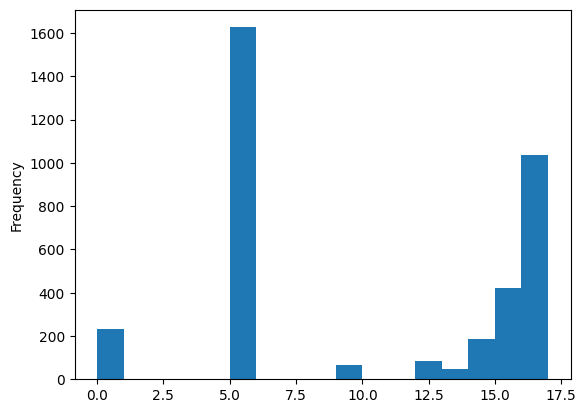

3470


In [5]:
row_notna_count = df.notna().sum(axis=1)
row_notna_count.plot.hist(bins=row_notna_count.max())
plt.show()

df = df[row_notna_count >= 2]
print(len(df))

# 텍스트를 토큰화했을 때 길이가 어느정도인지 확인해보기

학습을 위해서는 특정 길이로 자른 뒤 padding 처리를 해주어야하는데, 그러기 위해선 학습 데이터들의 길이가 어느정도인지 파악이 필요하다.

In [6]:
model_name = "gogamza/kobart-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


count    36793.000000
mean        13.147582
std          6.909344
min          1.000000
25%          8.000000
50%         12.000000
75%         17.000000
max        318.000000
dtype: float64

<Axes: ylabel='Frequency'>

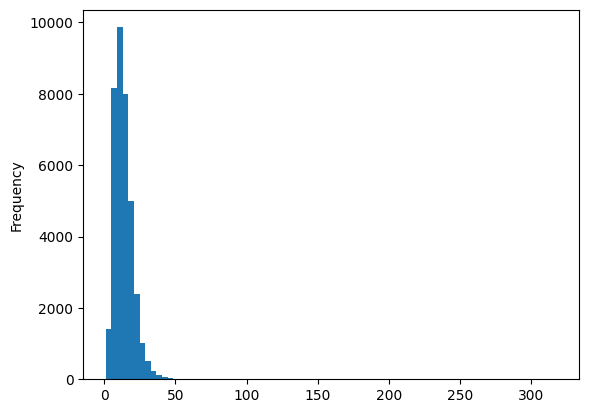

In [7]:
lengths = []

for column in df.columns:
  out = tokenizer(df[column][df[column].notna()].tolist())
  out = [len(x) for x in out['input_ids']]
  lengths.extend(out)

lengths = pd.Series(lengths)
display(lengths.describe())
lengths.plot.hist(bins=80)

정말 긴 문장도 있지만 대부분 토큰 길이가 50아래인 것을 볼 수 있다.

# Dataset class 만들기

In [8]:
style_map = {
    'formal': '문어체',
    'informal': '구어체',
    'android': '안드로이드',
    'azae': '아재',
    'chat': '채팅',
    'choding': '초등학생',
    'emoticon': '이모티콘',
    'enfp': 'enfp',
    'gentle': '신사',
    'halbae': '할아버지',
    'halmae': '할머니',
    'joongding': '중학생',
    'king': '왕',
    'naruto': '나루토',
    'seonbi': '선비',
    'sosim': '소심한',
    'translator': '번역기'
}

학습에 필요한 Dataset을 만든다, 여러 스타일을 가진 한 문장을 가져온 뒤, 두가지 스타일을 임의로 추출해서 하나를 원본 문장으로 지정하고 encoder의 입력으로 사용하고, 다른 하나를 목표 문장으로 decoder의 입력으로 사용한다.

In [9]:

class TextStyleTransferDataset(Dataset):
  def __init__(self, 
               df: pd.DataFrame, 
               tokenizer: Tokenizer
               ):
    self.df = df
    self.tokenizer = tokenizer
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index, :].dropna().sample(2)
    text1 = row[0]
    text2 = row[1]
    target_style = row.index[1]
    target_style_name = style_map[target_style]

    encoder_text = f"{target_style_name} 말투로 변환:{text1}"
    decoder_text = f"{text2}{self.tokenizer.eos_token}"
    model_inputs = self.tokenizer(encoder_text, max_length=64, truncation=True)

    with self.tokenizer.as_target_tokenizer():
      labels = tokenizer(decoder_text, max_length=64, truncation=True)
    model_inputs['labels'] = labels['input_ids']
    del model_inputs['token_type_ids']

    return model_inputs

In [10]:
dataset = TextStyleTransferDataset(df, tokenizer)
out = dataset[0]
print(out['input_ids'])
print(out['labels'])
print(tokenizer.decode(out['input_ids']))
print(tokenizer.decode(out['labels']))

out = dataset[1]
print(out['input_ids'])
print(out['labels'])
print(tokenizer.decode(out['input_ids']))
print(tokenizer.decode(out['labels']))

[14112, 11763, 12687, 14070, 13282, 10338, 14296, 13716, 257, 11699, 9592, 13586, 9531, 1700, 215, 14054, 1700, 11690, 9540, 12034, 14195, 10496, 24665, 14947, 11914, 9754, 14042, 258]
[22465, 232, 14651, 17849, 12034, 14195, 26832, 18712, 245, 1]
구어체 말투로 변환:안녕하냐 ㅡㅡ 나 씹냥이 6마리나 키운다 하;
안녕! 나는 고양이 6마리 키워.</s>
[14054, 10396, 13230, 14070, 13282, 10338, 14296, 13716, 257, 11696, 9735, 17849, 15188, 14195, 10496, 24665, 262, 14105, 13848, 9989, 27071]
[17849, 15188, 14195, 10496, 24665, 262, 25144, 9031, 15994, 12332, 14076, 9531, 9735, 9289, 262, 1]
나루토 말투로 변환:아니 고양이를 6마리나? 안힘드냐?
고양이를 6마리나? 키우는거 힘들지 않냐니깐?</s>


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [11]:
from sklearn.model_selection import train_test_split

# 학습을 위해 train, test set으로 나눈다.
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
print(len(df_train), len(df_test))

3123 347


In [12]:
train_dataset = TextStyleTransferDataset(
    df_train,
    tokenizer
)
test_dataset = TextStyleTransferDataset(
    df_test,
    tokenizer
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, model=model
)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [13]:
model_path = "/content/drive/MyDrive/data/text-transfer-smilegate-bart-eos/"

training_args = Seq2SeqTrainingArguments(
    output_dir=model_path, #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=24, # number of training epochs
    per_device_train_batch_size=16, # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    eval_steps=500, # Number of update steps between two evaluations.
    save_steps=1000, # after # steps model is saved 
    warmup_steps=300,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    evaluation_strategy="steps",
    save_total_limit=3
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [14]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,2.677100,1.795166
1000,1.607700,1.681927
1500,1.362200,1.477809
2000,1.247200,1.622919
2500,1.132100,1.452076
3000,1.054100,1.481639
3500,0.997400,1.540729
4000,0.961300,1.390609
4500,0.914100,1.600508


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your lab

TrainOutput(global_step=4704, training_loss=1.3090850544624588, metrics={'train_runtime': 827.5091, 'train_samples_per_second': 90.575, 'train_steps_per_second': 5.685, 'total_flos': 1551738795909120.0, 'train_loss': 1.3090850544624588, 'epoch': 24.0})

In [15]:
trainer.save_model("/content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/")

# Pipeline을 이용해서 학습한 모델로 텍스트 생성해보기

In [17]:
from transformers import pipeline

nlg_pipeline = pipeline('text2text-generation',model=model_path, tokenizer=model_name)

OSError: ignored

In [ ]:
def generate_text(pipe, text, target_style, num_return_sequences=5, max_length=60):
  target_style_name = style_map[target_style]
  text = f"{target_style_name} 말투로 변환:{text}"
  out = pipe(text, num_return_sequences=num_return_sequences, max_length=max_length)
  return [x['generated_text'] for x in out]

In [ ]:
target_styles = df.columns
src_text = """
어쩌다 마주친 그대 모습에
내 마음을 빼앗겨 버렸네
어쩌다 마주친 그대 두 눈이
내 마음을 사로잡아 버렸네
그대에게 할 말이 있는데
왜 이리 용기가 없을까
음 말을 하고 싶지만 자신이 없어
내 가슴만 두근두근
답답한 이 내 마음
바람 속에 날려 보내리
"""

print("입력 문장:", src_text)
for style in target_styles:
  print(style, generate_text(nlg_pipeline, src_text, style, num_return_sequences=1, max_length=1000)[0])